In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix

In [2]:
def generateNMF(patients_train,survived_train,patients_test,survived_test,n_components=30) :
    nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5)
    patients_trainnmf = nmf.fit_transform(patients_train)
    H = nmf.components_
    patients_testnmf = nmf.transform(patients_test)
    modelnmf = ajustLogisticRegression(patients_trainnmf,survived_train,patients_testnmf,survived_test)
    return nmf,modelnmf,patients_testnmf

In [3]:
def findpatient(message,table,beats):
    located = table
    groupsize = located.shape[0]
    deads = sum(located.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)

In [4]:
def print_top_words(model, feature_names, n_top_words,topics=[]):
    result = []
    for topic_idx, topic in enumerate(components):
        if(topics==[] or topic_idx in topics):
            features = [{"word":feature_names[i],"p1":str(topic[i])} for i in topic.argsort()[:-n_top_words - 1:-1] if topic[i] > 1]
            result.append({"topic":topic_idx,"features":features})
#        print(topic.argsort())
    return result

In [5]:
from operator import itemgetter
def sortBeats(compoT,table):
    predicts = modelnmf.predict_proba(compoT)[:,1]
    beats = list(table)
    n99,n90,n80,n70,alive = 0,0,0,0,0
    sortedBeats = []
    numPred = len(predicts)
    for i in range(0,numPred):
        sortedBeats.append({'word':beats[i],'predict':predicts[i]})
        if predicts[i]>.99 : n99+=1
        elif predicts[i]>.90 : n90+=1
        elif predicts[i]>.80 : n80+=1
        elif predicts[i]>.70 : n70+=1
        else: alive+=1
    print("over99:%d" %n99,"{0:.2%}".format(n99/numPred),"over90:%d" %n90,"{0:.2%}".format(n90/numPred),"over80:%d:"%n80,
          "{0:.2%}".format(n80/numPred),"over70:%d"%n70,"{0:.2%}".format(n70/numPred),"under:%d"%alive,
          "{0:.2%}".format(alive/numPred))
    return sorted(sortedBeats, key=itemgetter('predict'), reverse=True)

In [6]:
table = convert_matrix()

104899


In [7]:
table.sort_index(inplace=True,level='isAlive')
survived = table.index.labels[1].tolist()
patients = table.values

In [8]:
from sklearn.model_selection import train_test_split
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [9]:
from sklearn.decomposition import NMF
n_components=32
nmf,modelnmf,pat_testnmf = generateNMF(patients,survived,patients_test,survived_test,n_components=n_components)

acurracy is 78.08%


In [10]:
import numpy as np
compoT = np.transpose(nmf.components_)
print("components",nmf.components_.shape)
print("components Transpose",compoT.shape)

components (32, 8141)
components Transpose (8141, 32)


In [11]:
sortedBeats = sortBeats(compoT,table)
beatKeys = []
for value in sortedBeats:
    beatKeys.append(value['word'])

over99:110 1.35% over90:245 3.01% over80:854: 10.49% over70:6910 84.88% under:22 0.27%


Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística


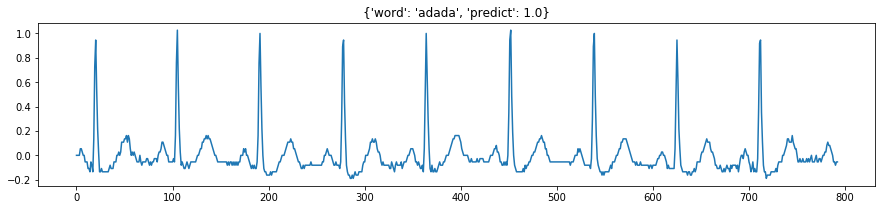

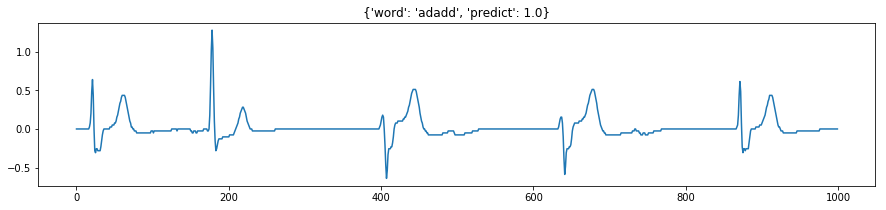

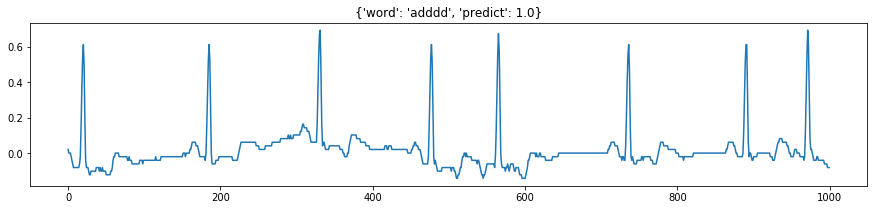

dadad 3791422 3792816 mimic2wdb/matched/s18243/s18243-2876-08-09-02-08


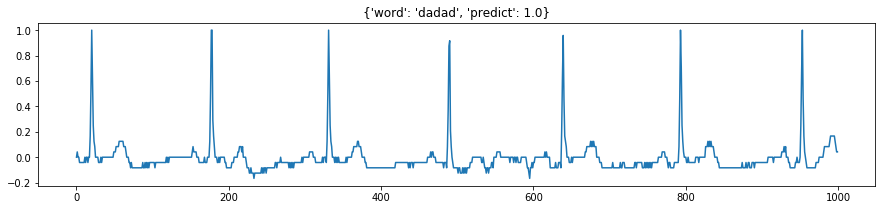

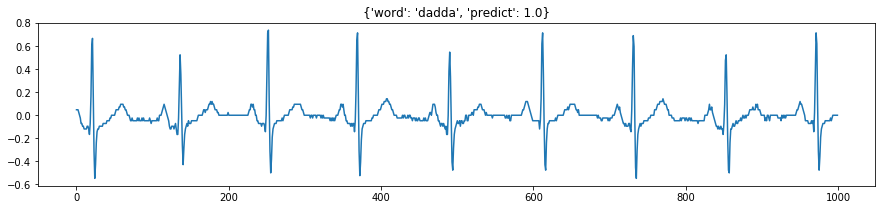

In [12]:
print("Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística")
plot_word(sortedBeats[:5])

In [13]:
table.sort_values(by=beatKeys)
survived = table.index.labels[1].tolist()
patients = table.values

In [14]:
nmf,modelnmf,pat_testnmf = generateNMF(patients,survived,patients_test,survived_test,n_components=n_components)

acurracy is 78.08%


In [15]:
components = nmf.components_

In [16]:
n_top_words = 1000
top_words = print_top_words(components, list(table), n_top_words)
for words in top_words:
    print(words['topic'],words['features'][:5])

0 [{'word': 'ababa', 'p1': '83.3795831434'}, {'word': 'babab', 'p1': '69.9040919323'}]
1 [{'word': 'eeeee', 'p1': '100.933239136'}]
2 [{'word': 'ddddd', 'p1': '49.827732745'}, {'word': 'dddda', 'p1': '1.87013299065'}, {'word': 'adddd', 'p1': '1.85109415342'}]
3 [{'word': 'babab', 'p1': '36.5795224104'}]
4 [{'word': 'adada', 'p1': '26.5294940537'}, {'word': 'aadad', 'p1': '26.3078393484'}, {'word': 'dadad', 'p1': '3.26250993487'}, {'word': 'adadd', 'p1': '3.21541750923'}, {'word': 'dadda', 'p1': '3.135075798'}]
5 [{'word': 'abbda', 'p1': '5.55199533967'}, {'word': 'aabbd', 'p1': '5.18572265572'}, {'word': 'dabba', 'p1': '4.98764711062'}, {'word': 'abbad', 'p1': '4.74384835818'}, {'word': 'bdaba', 'p1': '4.65397432675'}]
6 [{'word': 'eccec', 'p1': '8.55413286676'}, {'word': 'ccece', 'p1': '8.55019919686'}, {'word': 'cecce', 'p1': '7.79905128499'}, {'word': 'cecec', 'p1': '7.48322927909'}, {'word': 'ececc', 'p1': '7.20924681709'}]
7 [{'word': 'ddbdd', 'p1': '16.1053895409'}, {'word': 'ddd

In [17]:
components.shape

(32, 8141)

In [18]:
i,total=0,0
for component in components:
    i += 1
    total +=sum(component)
    print(sum(component),end=", ")
print(i,total,total/i)

156.014453956, 101.647953183, 64.2995970616, 41.4692622297, 100.268172403, 119.576277849, 106.988380676, 168.291148266, 163.995617664, 96.5267071592, 160.863534283, 83.8001253851, 287.009328669, 91.8928533187, 152.076609314, 299.287762979, 140.425721288, 245.027182227, 174.616937928, 211.51814498, 131.787886104, 33.1623721183, 130.419394411, 190.305361065, 139.814270584, 78.7529920798, 59.1057860796, 105.66600263, 161.614363501, 117.355064006, 92.2355202059, 180.935300432, 32 4386.75008403 137.085940126


In [19]:
patients_trainnmf = nmf.transform(patients_train)

In [20]:
from operator import itemgetter
from scipy.stats.stats import pearsonr
pearsonList = []
for i in range(n_components):
    patientpear=patients_trainnmf[:,i]
    pearson = pearsonr(patientpear,survived_train)
    if(pearson[0]>0):
        pearsonList.append({'word':i,'p1':pearson[0],'p2':pearson[1]})
sortedList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
for i in range(10):
    print(sortedList[i])

{'word': 16, 'p1': 0.085181283073763603, 'p2': 0.040119684397177162}
{'word': 19, 'p1': 0.054277890153705016, 'p2': 0.19139728746278908}
{'word': 15, 'p1': 0.054272542858434893, 'p2': 0.1914410991980286}
{'word': 23, 'p1': 0.053532551273255555, 'p2': 0.19757522859956847}
{'word': 17, 'p1': 0.05214486427164633, 'p2': 0.20946283901657331}
{'word': 5, 'p1': 0.043269161353460615, 'p2': 0.29778324427383251}
{'word': 31, 'p1': 0.043024823886840556, 'p2': 0.30052235395411697}
{'word': 14, 'p1': 0.042714810058433451, 'p2': 0.30402175084095573}
{'word': 25, 'p1': 0.042520641352779324, 'p2': 0.30622719689803041}
{'word': 9, 'p1': 0.041450126930469948, 'p2': 0.31857600078315185}


In [21]:
n_top_words = 10

topics = [sortedList[0]['word'],]
columns = list(table)
top_words = print_top_words(components, columns, 100,topics)
for words in top_words:
    print(words['topic'])
    features = words['features']
#print_top_beats(components, list(table), n_top_words,table,topics)

16


Top 5 HeartBeats con mayor correlación a la muerte según Pearson


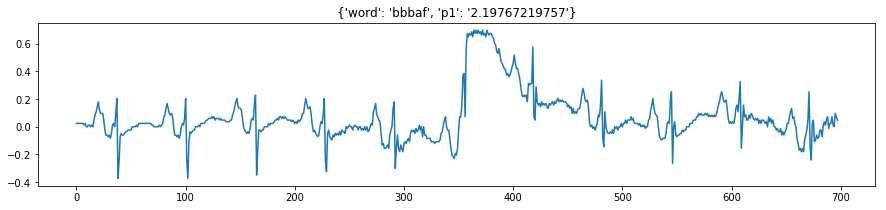

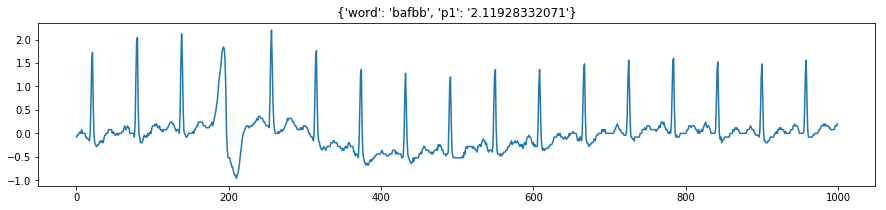

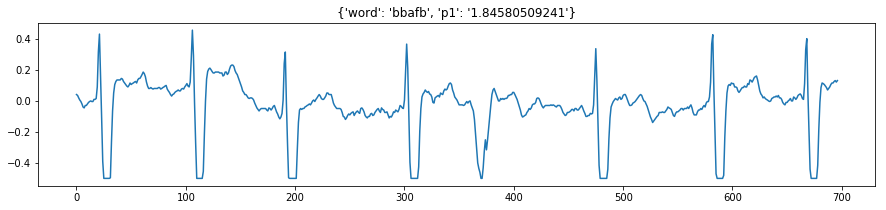

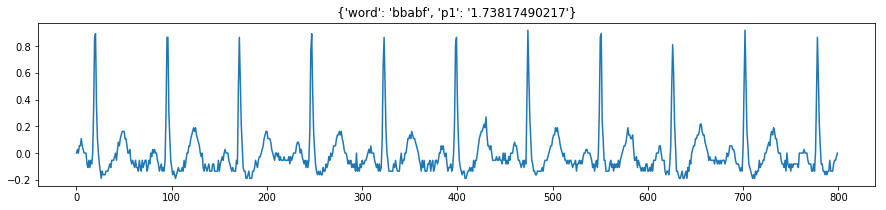

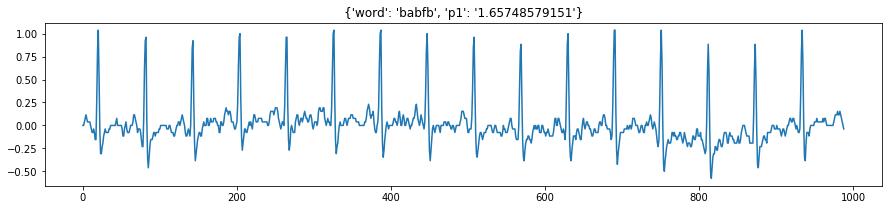

In [22]:
print("Top 5 HeartBeats con mayor correlación a la muerte según Pearson")
plot_word(features[:5])